# GPT-4 Vision demo

### Install libs as needed

In [ ]:
#%pip install openai --upgrade
#%pip install pypdfium2
#%pip install matplotlib

### Check installed versions

In [1]:
def check_openai_version():
    """
    Check Azure Open AI version
    """
    import openai

    installed_version = openai.__version__

    try:
        version_number = float(installed_version[:3])
    except ValueError:
        print("Invalid OpenAI version format")
        return

    print(f"Installed OpenAI version: {installed_version}")

    if version_number < 1.0:
        print("[Warning] You should upgrade OpenAI to have version >= 1.0.0")
        print("To upgrade, run: %pip install openai --upgrade")
    else:
        print(f"[OK] OpenAI version {installed_version} is >= 1.0.0")


check_openai_version()

Installed OpenAI version: 1.3.9
[OK] OpenAI version 1.3.9 is >= 1.0.0


### Import needed libs

In [2]:
import datetime
import openai
import os
import base64
import requests
import json
import sys

from dotenv import load_dotenv
from openai import AzureOpenAI
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams


### Using Azure Open AIs GPT4-Vision

#### Read environment variables into locals

In [3]:
load_dotenv()

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
GPT4V_KEY = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")
#
model=os.getenv("MODEL")
gpt4_vision_api_version=os.getenv("GPT4_VISION_API_VERSION")
temperature=os.getenv("TEMPERATURE")
top_p= os.getenv("TOP_P")
max_tokens= os.getenv("MAX_TOKENS")
gpt_4_endpoint= os.getenv("GPT4-V_ENDPOINT2")
#
#below for checking
print("openai.api_base = {}".format(openai.api_base))
print("temperature = {}".format(temperature))
print("top_p = {}".format(top_p))
print("max_tokens = {}".format(max_tokens))
print("gpt_4_endpoint = {}".format(gpt_4_endpoint))
print("model = {}".format(model))
print("model = {}".format(gpt4_vision_api_version))



openai.api_base = openai4west
temperature = 0.7
top_p = 0.95
max_tokens = 800
gpt_4_endpoint = https://openai4west.openai.azure.com/openai/deployments/preview-vision/chat/completions?api-version=2023-07-01-preview
model = preview-vision
model = 2023-07-01-preview


### Create a function to call the deployed model

In [27]:
# **************************************************
# Calls the GPT4V model passing in an image and text
# **************************************************
def gpt4V(image_file_name, query):
    # Endpoint
    base_url = f"https://{openai.api_base}.openai.azure.com/openai/deployments/{model}"
    endpoint = f"{base_url}/chat/completions?api-version={gpt4_vision_api_version}"
    #print("endpoint = {}".format(endpoint))
    #
    # get the files 3 character extension splitting on the period
    ext = os.path.splitext(image_file_name)[1][1:]
    if ext=="jpg":
        ext="jpeg"
    
    # Header
    headers = {"Content-Type": "application/json", "api-key": openai.api_key}

    # Encoded image
    base_64_encoded_image = base64.b64encode(open(image_file_name, "rb").read()).decode(
        "ascii"
    )
    payload={
        "messages": [
                        {
                            "role": "system",
                            "content": [
                                {
                                    "type": "text",
                                    "text": "You are an AI assistant that helps people find information."
                                }
                            ]
                        },
                        {
                            "role": "user",
                            "content": [
                                {
                                    "type": "image_url",
                                    "image_url": {
                                        "url": "data:image/" + ext +";base64," + base_64_encoded_image
                            }
                                },
                                {
                                    "type": "text",
                                    "text": query
                                }
                            ]
                        }
        ],
        "temperature": temperature,
        "top_p": top_p,
        "max_tokens": 800
    }
    # Results
    #print(payload)
    response = requests.post(endpoint, headers=headers, json=payload)
    #print(response)
    ##
    ## Check for errors
    if response.status_code == 200:
        result = json.loads(response.text)["choices"][0]["message"]["content"]
        return result
    if response.status_code == 429:
        print("[ERROR] Too many requests. Please wait a couple of seconds and try again.")
    else:
        print("[ERROR] Error code:", response.status_code)

### Examples with sample pages from a PDF converted to JPGs first.
#### Frrst lets create some helper functions
One dunction to convert a PDF page to an image.  
The other two functions are for showing the images

In [11]:
import pypdfium2 as pdfium

# ******************************
# renders a image from a pdf page
# save the imahe to disk
# ******************************
def save_pdf_page_to_image(pdf_file_path, page_number):
    # get the pdf
    pdf = pdfium.PdfDocument(pdf_file_path)
    #
    # get the page
    page = pdf[page_number]
    #
    # render image
    pil_image = page.render(scale=4).to_pil()
    #
    #get the file name from the path that was passed in
    pdf_file_name = os.path.splitext(pdf_file_path)[0]
    image_file_name = pdf_file_name + "_page_" + str(page_number) + ".jpg"
    #
    # save the image
    pil_image.save(image_file_name)
    #print("Image of page {} has been saved!".format(page_number))
    return image_file_name

def show_image(image_file_name):
    image = plt.imread(image_file_name)
    plt.imshow(image)
    plt.show()

    
import matplotlib.patches as patches

def show_two_images(img1, img2, border_size=10):
    fig, axs = plt.subplots(1, 2)

    # Create a larger black image
    bordered_img1 = np.pad(img1, [(border_size, ), (border_size, ), (0, )], mode='constant', constant_values=0)
    bordered_img2 = np.pad(img2, [(border_size, ), (border_size, ), (0, )], mode='constant', constant_values=0)

    # Show first image with border
    axs[0].imshow(bordered_img1)
    axs[0].axis('off')  # Hide axes

    # Show second image with border
    axs[1].imshow(bordered_img2)
    axs[1].axis('off')  # Hide axes

    plt.subplots_adjust(wspace=0.05)  # Adjust space between subplots
    plt.show()
    

        

## Example 1
### OCR the text and describe a figure

Image of page 22 in PDF ./images/FMDS0200.pdf has been saved as ./images/FMDS0200_page_22.jpg!


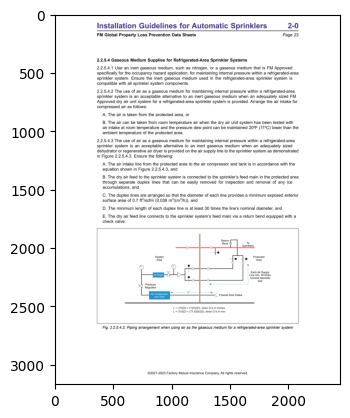

In [16]:
# Convert the PDF page to an image
page = 22
pdf_file_path = "./images/FMDS0200.pdf"
image_file_name=save_pdf_page_to_image(pdf_file_path, page)
print("Image of page {} in PDF {} has been saved as {}!".format(page, pdf_file_path, image_file_name))
#
show_image(image_file_name)


In [28]:
# make the call to GPT4V
result = gpt4V(image_file_name, "Return the text from this page and describe any figures on the page.")
#
# show the result
print(result)

The text from the page is as follows:

Installation Guidelines for Automatic Sprinklers 2-0
FM Global Property Loss Prevention Data Sheets
Page 23

2.2.5.4 Gaseous Medium Supplies for Refrigerated-Area Sprinkler Systems

2.2.5.4.1 Use an inert gaseous medium, such as nitrogen, or a gaseous medium that is FM Approved specifically for the occupancy hazard application, for maintaining internal pressure within a refrigerated-area sprinkler system. Ensure the inert gaseous medium used in the refrigerated-area sprinkler system is compatible with all sprinkler system components.

2.2.5.4.2 The use of air as a gaseous medium for maintaining internal pressure within a refrigerated-area sprinkler system is an acceptable alternative to an inert gaseous medium when an adequately sized FM Approved dry air unit system for a refrigerated-area sprinkler system is provided. Arrange the air intake for compressed air as follows:

A. The air is taken from the protected area, or

B. The air can be taken fr

## Example 2 
### Get just the red text

Image of page 45 in PDF ./images/FMDS0128.pdf has been saved as ./images/FMDS0128_page_45.jpg!


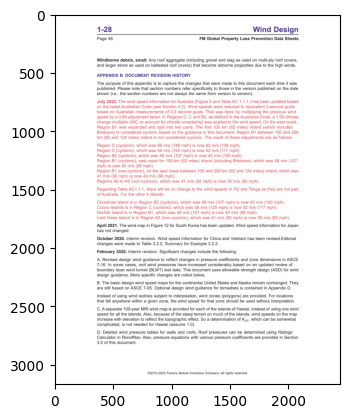

In [29]:
# Convert the PDF page to an image
page = 45
pdf_file_path = "./images/FMDS0128.pdf"
image_file_name=save_pdf_page_to_image(pdf_file_path, page)
print("Image of page {} in PDF {} has been saved as {}!".format(page, pdf_file_path, image_file_name))
#
show_image(image_file_name)
#

In [30]:
# make the api call
result = gpt4V(image_file_name, "how many colors of text are on the page?")
print(result)

There are three colors of text on the page: black, red, and blue.


The Prompt is important to get the result needed

In [32]:
# maintaining state
prompt= result+ " " + "Return only the red colored text from this page, do not return any other colored text. Do not return the black text. Do not return the blue text"
prompt= prompt + " " + "Be very precise in your answer and only return the red text exactly as it it in the page. Return all of the red colored text. Do not return any other text."
result = gpt4V(image_file_name, prompt)
print(result)

Region D (cyclonic), which was 68 m/s (152 mph) is now 62 m/s (138 mph).
Region D (cyclonic), which was 56 m/s (125 mph) is now 52 m/s (117 mph).
Region C (cyclonic), which was 48 m/s (107 mph) is now 45 m/s (100 mph).
Cocos Islands is in Region C (cyclonic), which was 56 m/s (125 mph) is now 52 m/s (117 mph).
Norfolk Island is in Region B1 (cyclonic), which was 48 m/s (107 mph) is now 43 m/s (96 mph).
Lord Howe Island is in Region A2 (non-cyclonic), which was 41 m/s (92 mph) is now 36 m/s (82 mph).


## Example 3 
#### Determine the windspeed of a city from a map

Image of page 48 in PDF ./images/FMDS0128.pdf has been saved as ./images/FMDS0128_page_48.jpg!


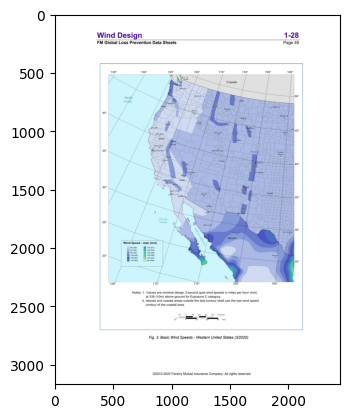

In [33]:
# Convert the page to an image
page = 48
pdf_file_path = "./images/FMDS0128.pdf"
image_file_name=save_pdf_page_to_image(pdf_file_path, page)
print("Image of page {} in PDF {} has been saved as {}!".format(page, pdf_file_path, image_file_name))
#
# Show the image
show_image(image_file_name)
#

#### To get the proper result use chain of thought

In [34]:
prompt="what does the legend on the Figure on this page detail?"
result = gpt4V(image_file_name, prompt)
print(result)

The legend on the figure details the wind speed in miles per hour (mph) and meters per second (m/s). It provides a color-coded scale indicating different wind speeds, ranging from less than 80 mph (35 m/s) to greater than 150 mph (67 m/s). Each wind speed range is associated with a specific color used on the map to denote the areas where those wind speeds are the nominal design 3-second gust wind speeds at 33ft (10m) above ground for Exposure C category.


In [35]:
# mainaining state from previous call
prompt=result + " " + "The cities on the map are represented by black dots next to the city name."
prompt=prompt + " " + "It is not the color surrounding the city name that is important for determing wind speed, it is the color surrounding the black dot."
prompt=prompt + " " + "Is Denver, CO shown in the figure and if so what is the wind speed value for Denver, CO?"
result = gpt4V(image_file_name, prompt)
print(result)

Yes, Denver, CO is shown on the figure. You can locate Denver by finding the black dot labeled with the city's name in the state of Colorado. The color surrounding the black dot representing Denver appears to be within the lightest blue range on the map. According to the legend, this lightest blue corresponds to wind speeds of less than 90 mph (40 m/s). Therefore, the wind speed value for Denver, CO, is less than 90 mph.


## Example 4
### Testing its geographcal understanding

Image of page 55 in PDF ./images/FMDS0128.pdf has been saved as ./images/FMDS0128_page_55.jpg!


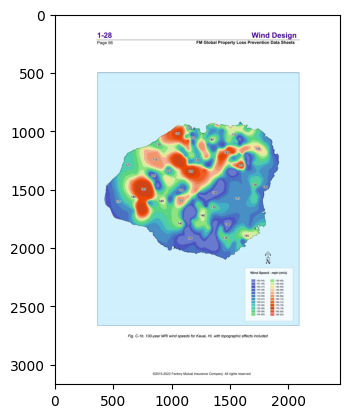

In [36]:
page = 55
pdf_file_path = "./images/FMDS0128.pdf"
image_file_name=save_pdf_page_to_image(pdf_file_path, page)
print("Image of page {} in PDF {} has been saved as {}!".format(page, pdf_file_path, image_file_name))
#
show_image(image_file_name)
#

In [37]:
prompt="based on the Figure on this page, which part of the island has the strongest winds?"
result = gpt4V(image_file_name, prompt)
print(result)

Based on the figure provided, the strongest winds are indicated by the warmest colors (reds and oranges). It appears that the central and northeastern parts of the island have the strongest winds, as these areas have numbers like 165 and 175, which correspond to the highest wind speed values on the legend.


## Example 5
 In this example the text on page 17 describes an image on page 19  
 so the result of the OCR scrape of page 17 is maintained and passed  
 in alogng with the image on page 19 and the question

Image of page 17 in PDF ./images/FMDS1202.pdf has been saved as ./images/FMDS0128_page_55.jpg!
Image of page 19 in PDF ./images/FMDS1202.pdf has been saved as ./images/FMDS0128_page_55.jpg!


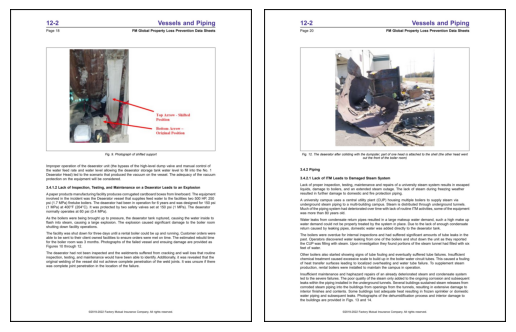

In [38]:
# Convert both pages to images
from matplotlib.pyplot import imread
page = 17
pdf_file_path = "./images/FMDS1202.pdf"
image_file_name1=save_pdf_page_to_image(pdf_file_path, page)
print("Image of page {} in PDF {} has been saved as {}!".format(page, pdf_file_path, image_file_name))
#
page = 19
image_file_name2=save_pdf_page_to_image(pdf_file_path, page)
print("Image of page {} in PDF {} has been saved as {}!".format(page, pdf_file_path, image_file_name))
#
# Show the images side by side
img1 = imread(image_file_name1)
img2 = imread(image_file_name2)
show_two_images(img1, img2)


In [40]:
# Do the OCR scrape of the first page
prompt="Return the text from this page"
# passing in the first page - page 17
result = gpt4V(image_file_name1, prompt)
print(result)

12-2 Vessels and Piping
Page 18 FM Global Property Loss Prevention Data Sheets

Fig. 9. Photograph of shifted support

Improper operation of the deaerator unit (the bypass of the high-level dump valve and manual control of the water feed rate and water level allowing the deaerator storage tank water level to fill into the No. 1 Deaerator Head) led to the scenario that produced the vacuum on the vessel. The adequacy of the vacuum protection on the equipment will be considered.

3.4.1.2 Lack of Inspection, Testing, and Maintenance on a Deaerator Leads to an Explosion

A paper products manufacturing facility produces corrugated cardboard boxes from linerboard. The equipment involved in the incident was the Deaerator vessel that supplies feed water to the facilities two 500 HP, 250 psi (1.7 MPa) firetube boilers. The deaerator had been in operation for 6 years and was designed for 150 psi (1 MPa) at 400°F (204°C). It was protected by two safety valves set at 150 psi (1 MPa). The deaerator 

In [42]:
# maintaing state from the previous call about page 17
# and passing in a new page - page 19 with my question
prompt= result + " " + "Based on the text on the prior pages read and on this page, what caused the damage show in Figure 12?"
prompt= prompt + " " + "If there are multiple contributing factors, list them all"
result = gpt4V(image_file_name2, prompt)
print(result)

Based on the provided page and the context given, the damage shown in Figure 12 was caused by the following contributing factors:

1. Lack of proper inspection, testing, and maintenance of the university steam system, which led to escaped liquids, damage to boilers, and an extended steam outage.
2. The lack of steam during freezing weather resulted in further damage to domestic and fire protection piping.
3. The university campus used a central utility plant (CUP) housing multiple boilers to supply steam via underground steam piping to a multi-building campus. The steam is distributed through underground tunnels. The lack of proper inspection, testing, and maintenance over time led to deterioration and damage.
4. Water leaks from condensate return pipes required a large makeup water demand, and the system in place could not properly treat the water due to a lack of enough condensate return caused by leaking pipes, leading to the system being directly connected to the deaerator tank.
5.